#### Atividade 3

Treinem um modelo caixa-preta (e.g., Random Forest) para uma base de dados do seu interesse. Crie um global surrogate caixa-branca (e.g., árvore de decisão), que simule esse modelo caixa-preta aprendido. Façam o upload do notebook.

# **Global Surrogates**

De uma forma geral, surrogate é um modelo substituto. No contexto de interpretabilidade, o surrogate é um modelo caixa-branca que simula as predições de um modelo caixa-preta. Podemos pensar em modelos surrogates globais ou locais, quando se deseja simular as predições de um modelo para todo um conjunto de dados ou apenas para uma determinada região em torno de uma instância específica que se deseja explicar. Nesse notebook, apresentamos os modelos surrogates globais.

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

**READING THE DATA FRAME**

O dataset em questão consiste em um conjunto de status de personagens de D&D, para que possamos identificar qual a raça o personagem pertence.

In [61]:
df = pd.read_csv('/content/drive/MyDrive/Mestrado/Mestrado_CIn_2023/Topicos em IC 2/Atividade 3 - Global surrogate/Data/stats.csv')

df.head()

,race,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma
0,dragonborn,79,279,30,14,15,12,7,13,16
1,dragonborn,79,331,30,11,11,11,13,13,17
2,dragonborn,71,230,30,14,16,11,13,10,18
3,dragonborn,75,265,30,8,19,7,10,13,16
4,dragonborn,72,229,30,8,17,14,14,10,9


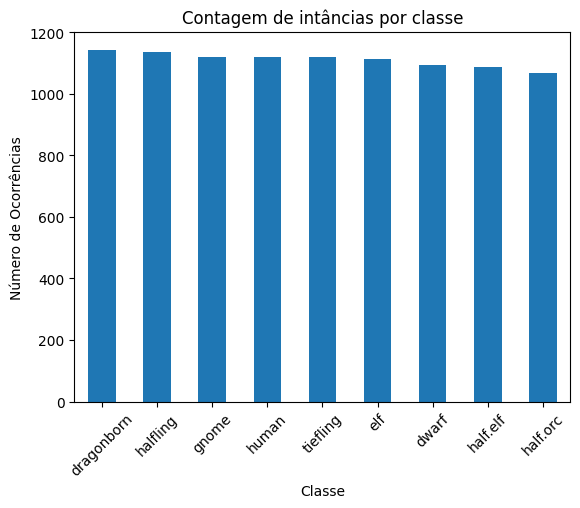

In [62]:
import matplotlib.pyplot as plt

# Contando o número de ocorrências de cada classe
contagem_classes = df['race'].value_counts()

# Plotando o resultado
contagem_classes.plot(kind='bar')
plt.title('Contagem de intâncias por classe')
plt.xlabel('Classe')
plt.ylabel('Número de Ocorrências')
plt.xticks([0, 1,2,3,4,5,6,7,8], list(contagem_classes.keys()), rotation=45) # Ajustando os rótulos do eixo x
plt.show()

Como é possível ver acima a distribuição de instâncias por classe é bem balanceada.

**TRAINING EXAMPLES**

In [63]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['race'])
Y = df['race']

# Separando os dados em treinamento(75%) e teste(25%)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

**--- LEARNING THE RF CLASSIFIER**

Aprendendo o modelo

In [7]:
from sklearn.inspection import PartialDependenceDisplay

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, Y_train)

Agora usando o modelo para gerar predições

In [11]:
from sklearn.metrics import f1_score
Y_pred = rf.predict(X_test)
f1_score(Y_test,Y_pred,average='macro')

0.6482508633562252

**--- BUILDING THE SURROGATE MODEL**

Note que no modelo surrogate os atributos preditores continuam os mesmos mas o atributo alvo agora é a predição do modelo base que se deseja explicar. Nesse exmeplo, abaixo uma árvore de decisão é aprendida usando as predições do modelo base para os dados de teste.

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 4,min_samples_leaf = 200)

dt.fit(X_test, Y_pred)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=200)

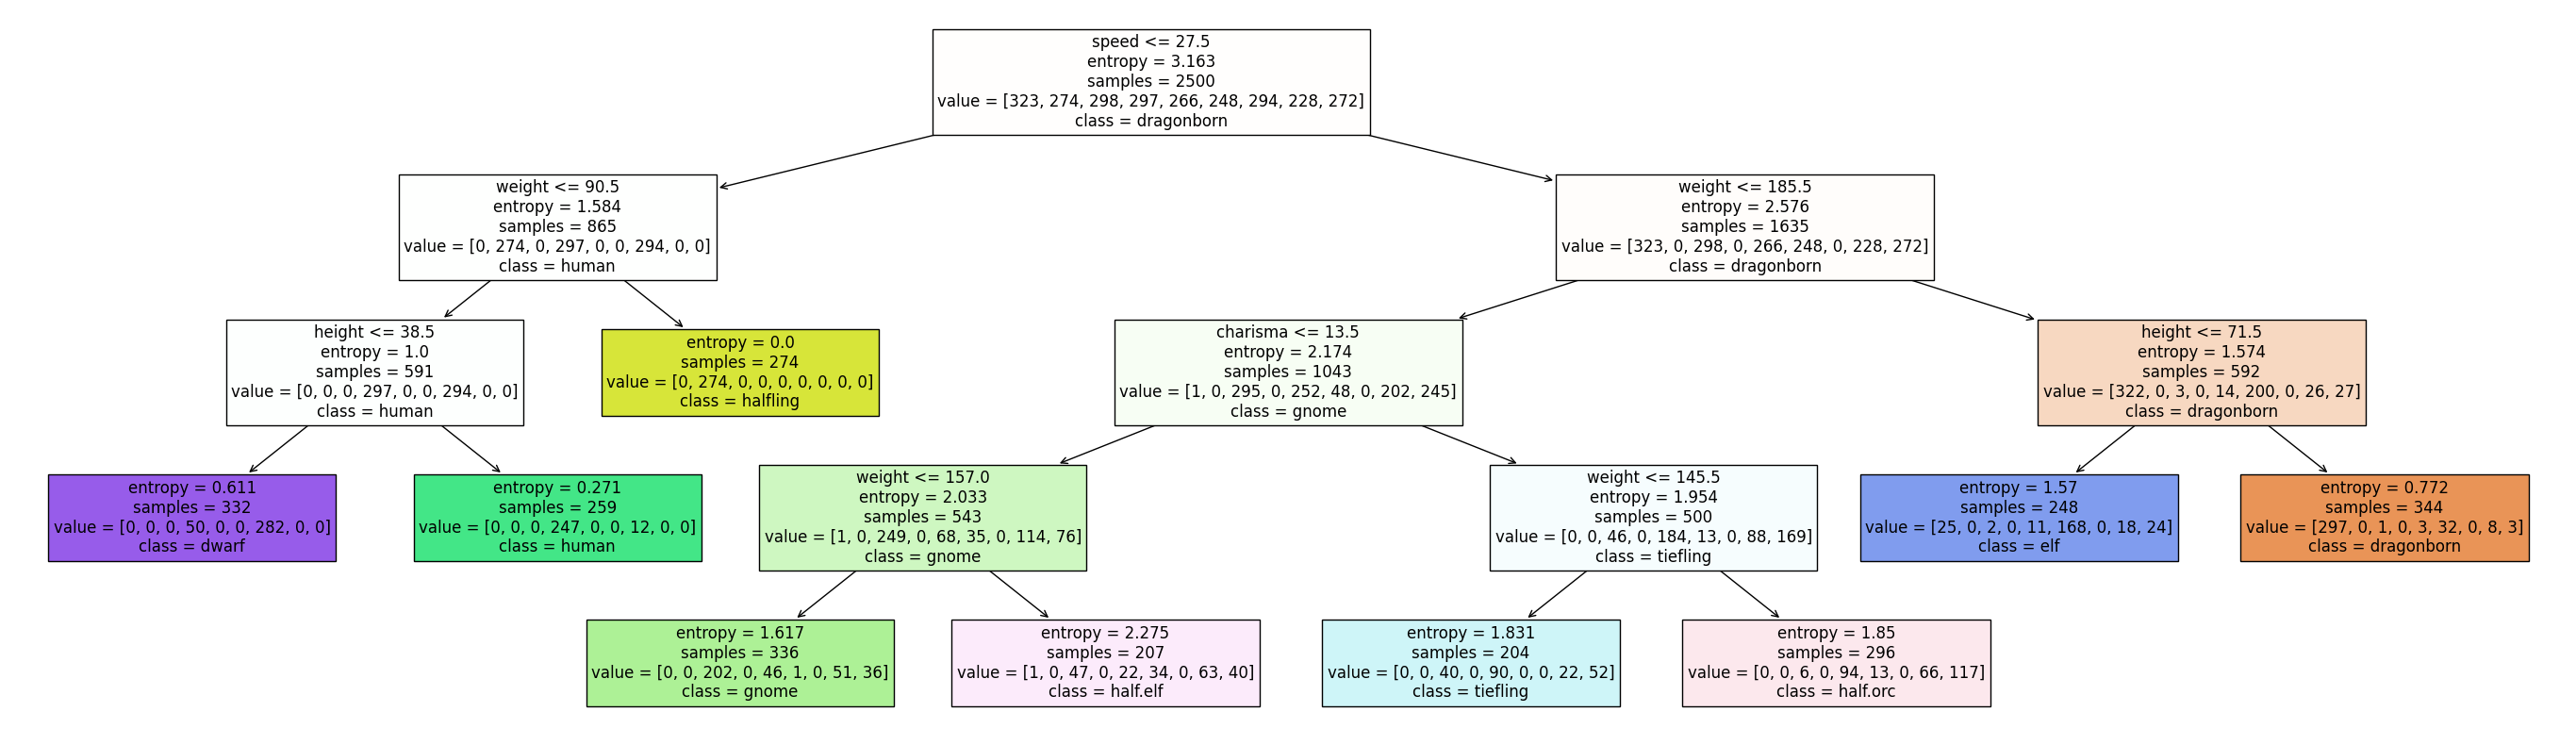

In [29]:
from sklearn import tree

plt.figure(figsize=(35,10))
tree.plot_tree(dt, feature_names = X.columns, class_names=contagem_classes.keys(),filled = True,fontsize=12);

Como pode ser visto acima a arvore de decisões possui um nó final para cada classe com a profundidade escolhida.

Além disso, apesar de possuir acesso aos atributos dos personagens, apenas 1 dos nós de toda a arvore chegou a usar algum atributo, que foi o carisma (ambas as raças são comuns para personagens de carisma alto como paladino e barbaro).

TODOS os demais nós foram construidos a partir exclusivamente das variáveis de peso e altura

**Building the global surrogate from a cross-validation experiment**

A validação cruzada variará o grupo de testes de modo que o Y_pred final seja do tamanho da base original toda, garantindo uma base de testes mais robusta e representativa para a arvore de decisão

In [41]:
from sklearn.model_selection import cross_val_predict

rf = RandomForestClassifier()

Y_pred = cross_val_predict(rf, X, Y, cv=10)

In [46]:
f1_score(y_pred=Y_pred,y_true=Y,average='macro')

0.6603086890379494

In [52]:
# Convertendo para um Series do pandas
# Exemplo de criação da Series, substitua isso pela sua Series real
races = pd.Series(Y_pred)

# Contando a frequência de cada raça
race_counts = races.value_counts()

# Imprimindo os resultados
print(race_counts)

dragonborn    1349
halfling      1135
elf           1127
gnome         1121
tiefling      1120
dwarf         1095
half.elf      1064
half.orc      1045
human          944
dtype: int64


In [53]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5,min_samples_leaf = 600)

dt.fit(X, Y_pred)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=600)

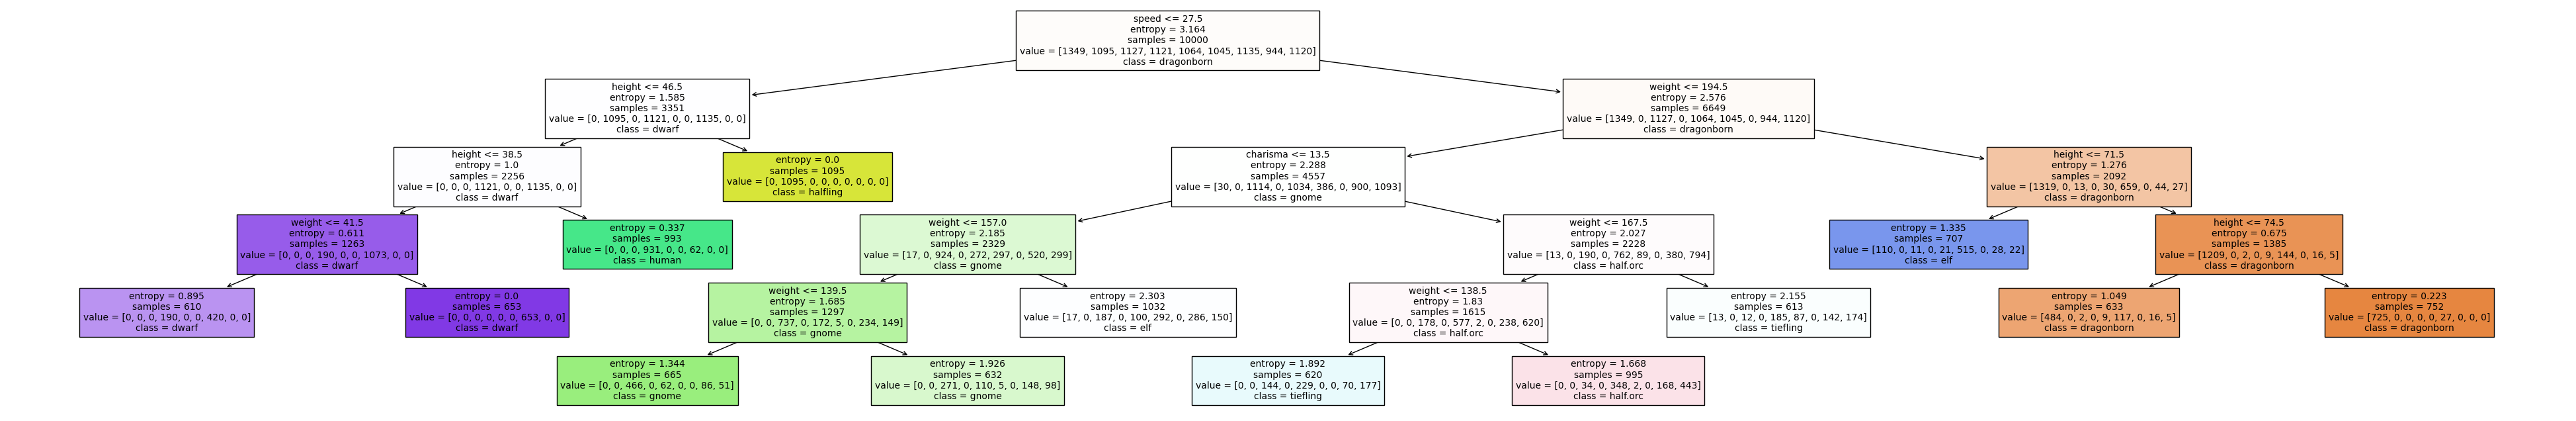

In [54]:
plt.figure(figsize=(50,8))
tree.plot_tree(dt, feature_names = X.columns, class_names=contagem_classes.keys(),filled = True,fontsize=10);

# Visualização do modelo caixa branca

Antes de visualizar a representação visual do modelo caixa branca, faremos um novo treinamento com cross validation, todavia desta vez usando apenas as variáveis presentes no modelo caixa branca para ver se o modelo caixa preta será afetado.

In [73]:
reduced_X = df.drop(columns=['race','strength','dexterity','constitution','intelligence','wisdom'])
Y = df['race']

rf = RandomForestClassifier()
Y_pred = cross_val_predict(rf, reduced_X, Y, cv=10)

f1_score(y_pred=Y_pred,y_true=Y,average='macro')

0.7694558190940118

## redução da dimensionalidade

Para possibilitar a visualização dos modelos faremos uma redução de dimensionalidade usando PCA para 2 dimensões apenas.

In [77]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Exemplo usando PCA
pca = PCA(n_components=2)
pca_reduced_X = pca.fit_transform(reduced_X)

Treinando ambos modelos novamente para verificar a representação do modelo caixa branca em um plot 2d

In [78]:
from sklearn.model_selection import cross_val_predict

rf = RandomForestClassifier()

Y_pred = cross_val_predict(rf, pca_reduced_X, Y, cv=10)

In [79]:
f1_score(y_pred=Y_pred,y_true=Y,average='macro')

0.8149162182137554

Impressionantemente, a redução de dimensão conseguiu mais uma vez otimizar o resultado em relação ao primeiro treinamento realizado.

In [80]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5,min_samples_leaf = 600)

dt.fit(pca_reduced_X, Y_pred)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=600)

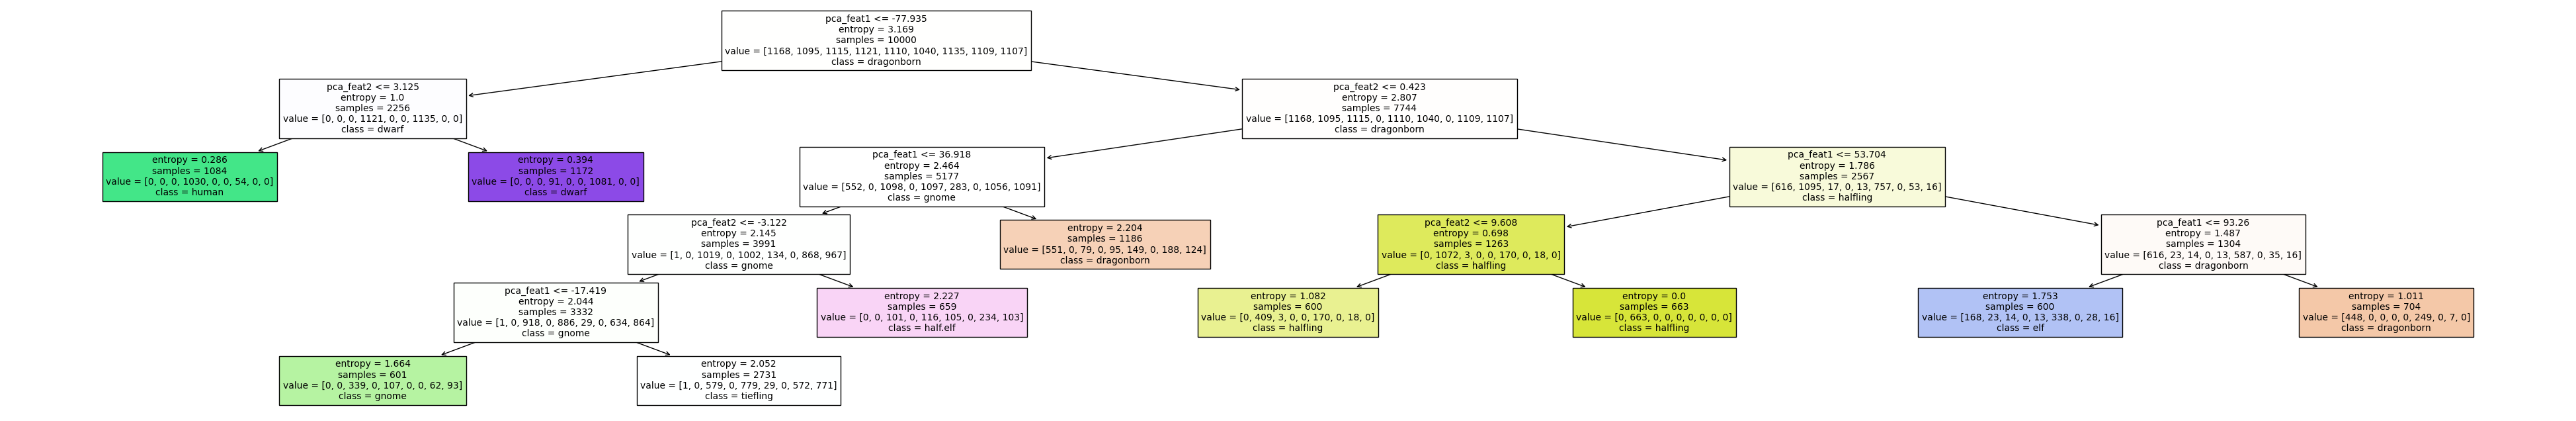

In [82]:
plt.figure(figsize=(50,8))
tree.plot_tree(dt, feature_names = ['pca_feat1','pca_feat2'], class_names=contagem_classes.keys(),filled = True,fontsize=10);

Verificando intervalos de valores das variáveis para criação do blob e consequente vizualização dos modelos

In [98]:
pca_reduced_X[:,0].min(),pca_reduced_X[:,1].min(),pca_reduced_X[:,0].max(),pca_reduced_X[:,1].max(),

(-110.91753649563532,
 -16.558961460417112,
 220.67103546694298,
 20.185717491988285)

O modelo caixa branca nos ajudou a compreender quais features eram verdadeiramente importantes e portanto nos permitiu otimizar o modelo caixa preta através da exclusão das features que não apresentaram importância para o modelo caixa branca.

Gerando uma grande quantidade de dados para verificar qual a superfície de separação definida pelo modelo RF e pelo seu surrogate

In [99]:
n = 5000
xy_min = [-150, -20]
xy_max = [250,25]
data = np.random.uniform(low=xy_min, high=xy_max, size=(n,2))

Gerando as predições do modelo RF e plotando

In [100]:
trained_rf = rf.fit(pca_reduced_X,Y)
Y_pred2 = trained_rf.predict(data)

In [106]:
races = {'dragonborn': 0,
 'dwarf':1,
 'elf':2,
 'gnome':3,
 'half.elf':4,
 'half.orc':5,
 'halfling':6,
 'human':7,
 'tiefling':8}

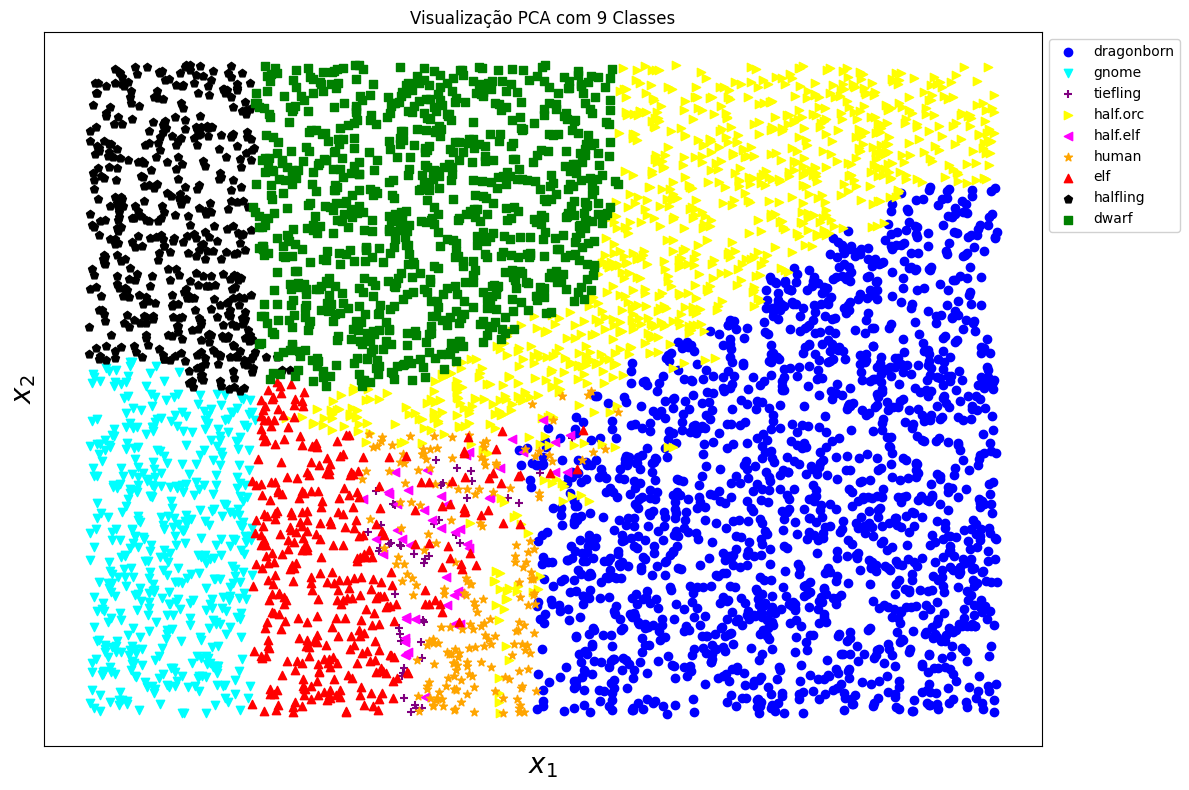

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Definindo marcadores e cores para cada uma das 9 classes
markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', '+']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']

# Plotando os dados
for race in set(Y_pred2):
    plt.scatter(data[:, 0][Y_pred2 == race], data[:, 1][Y_pred2 == race], marker=markers[races[race]], color=colors[races[race]], label=f'{race}')

# Adicionando rótulos e título ao gráfico
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)
plt.title("Visualização PCA com 9 Classes")

# Removendo os eixos
plt.xticks([])
plt.yticks([])

# Adicionando uma legenda fora do gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.9)

# Ajustar o layout para levar em conta o tamanho da legenda
plt.tight_layout()

# Exibindo o gráfico
plt.show()


Gerando as predições do modelo surrogate e plotando

In [101]:
Y_pred3 = dt.predict(data)

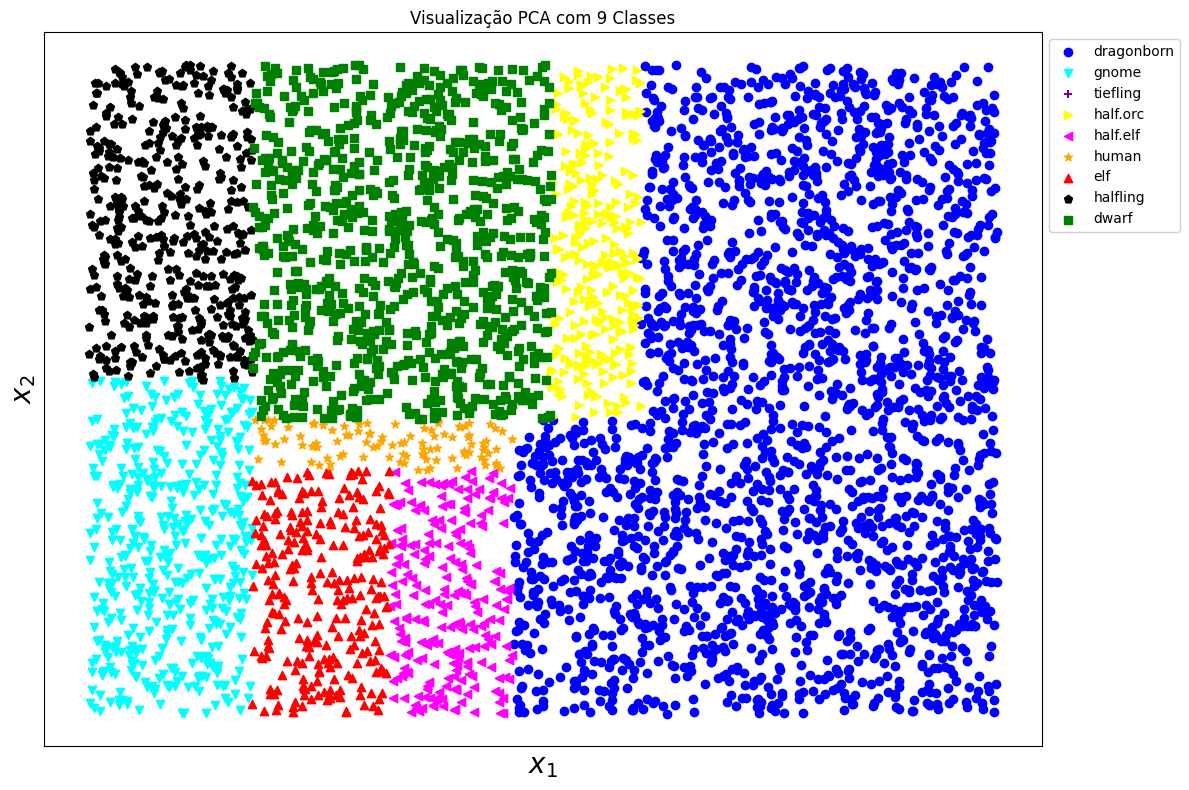

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Definindo marcadores e cores para cada uma das 9 classes
markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', '+']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']

# Plotando os dados
for race in set(Y_pred2):
    plt.scatter(data[:, 0][Y_pred3 == race], data[:, 1][Y_pred3 == race], marker=markers[races[race]], color=colors[races[race]], label=f'{race}')

# Adicionando rótulos e título ao gráfico
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)
plt.title("Visualização PCA com 9 Classes")

# Removendo os eixos
plt.xticks([])
plt.yticks([])

# Adicionando uma legenda fora do gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.9)

# Ajustar o layout para levar em conta o tamanho da legenda
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Como pode ser visto acima o modelo caixa branca conseguiu representar o modelo final de maneira bem eficiente, com exceção das regiões de borda de maior complexidade, dada a limitação do próprio algoritmo decision tree. Isso é visualizado de melhor maneira para a classe half elf que possui caracteristicas em comum com todas as raças nas regiões próximas, de modo que a raça tiefling foi completamente 'engolida' pela raça half.elf